# Sentiment Analysis of Dropbox App Reviews
Roll Number: 240103049

In [1]:

# Install required libraries (run once)
!pip install google-play-scraper nltk textblob vaderSentiment wordcloud scikit-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 6.6 MB/s eta 0:00:00


In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google_play_scraper import Sort, reviews
import nltk
import re
import string

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud


In [3]:

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [4]:

app_id = "com.dropbox.android"

review_data, _ = reviews(
    app_id,
    lang='en',
    country='us',
    sort=Sort.NEWEST,
    count=1200
)

df = pd.DataFrame(review_data)
df = df[['content', 'score', 'at']]
df.rename(columns={'content':'review','score':'rating','at':'date'}, inplace=True)
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)
df.head()


,review,rating,date
0,nice,5,2026-02-15 10:04:36
1,very poor communication. when you have a probl...,1,2026-02-14 22:21:09
2,Great storage 🙂,5,2026-02-14 20:40:55
3,Awesome App,5,2026-02-14 19:23:41
4,Great service until it comes time to cancel. Y...,1,2026-02-14 17:17:18


In [7]:
nltk.download('punkt_tab')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

df['clean_review'] = df['review'].apply(clean_text)
df.head()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,review,rating,date,clean_review
0,nice,5,2026-02-15 10:04:36,nice
1,very poor communication. when you have a probl...,1,2026-02-14 22:21:09,poor communication problem one help going tomo...
2,Great storage 🙂,5,2026-02-14 20:40:55,great storage 🙂
3,Awesome App,5,2026-02-14 19:23:41,awesome app
4,Great service until it comes time to cancel. Y...,1,2026-02-14 17:17:18,great service come time cancel cant cancel app...


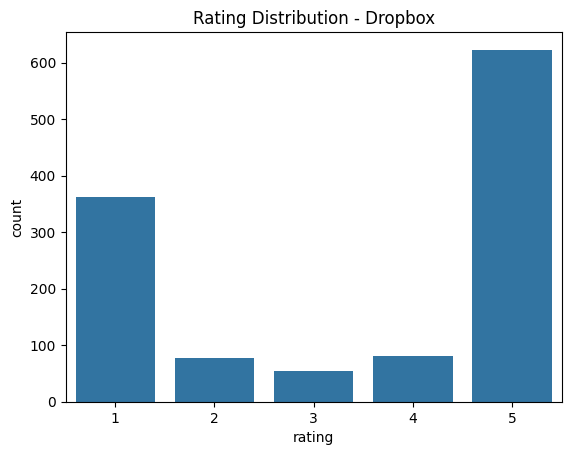

In [8]:

sns.countplot(x='rating', data=df)
plt.title("Rating Distribution - Dropbox")
plt.show()


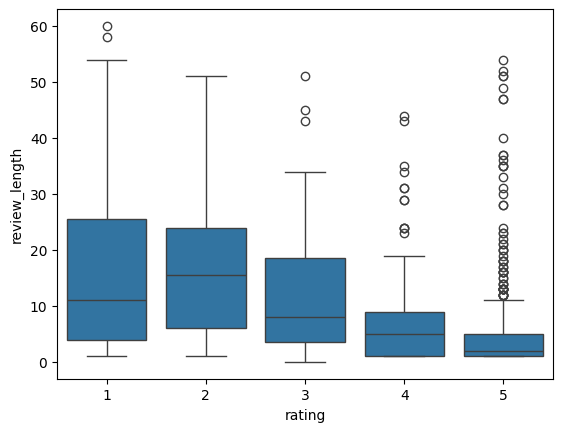

In [9]:

df['review_length'] = df['clean_review'].apply(lambda x: len(x.split()))
sns.boxplot(x='rating', y='review_length', data=df)
plt.show()


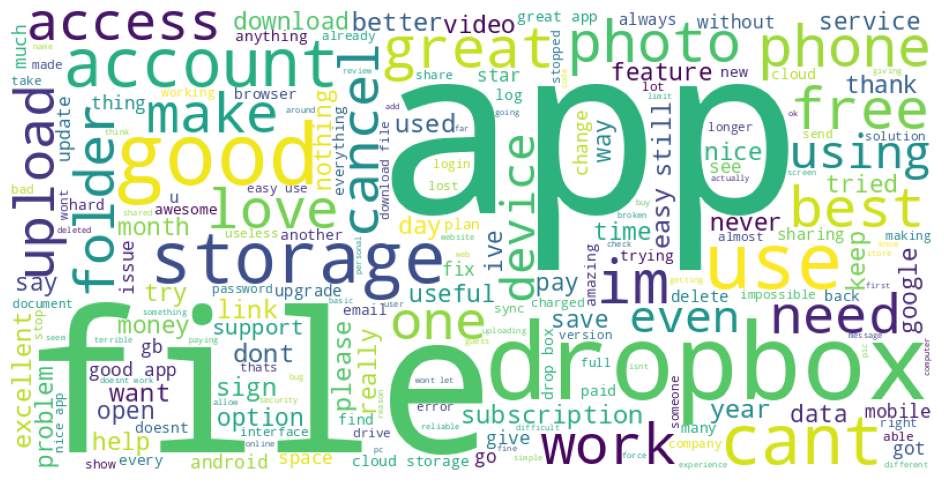

In [10]:

wordcloud = WordCloud(width=800, height=400, background_color='white')
wordcloud.generate(" ".join(df['clean_review']))
plt.figure(figsize=(12,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


In [11]:

df['textblob_polarity'] = df['clean_review'].apply(lambda x: TextBlob(x).sentiment.polarity)

def label_sentiment(score):
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'

df['textblob_sentiment'] = df['textblob_polarity'].apply(label_sentiment)


In [12]:

analyzer = SentimentIntensityAnalyzer()
df['vader_score'] = df['clean_review'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
df['vader_sentiment'] = df['vader_score'].apply(label_sentiment)


In [13]:

pricing_keywords = ['price','pricing','expensive','cost','subscription','storage','space']
df['pricing_related'] = df['clean_review'].apply(lambda x: any(word in x for word in pricing_keywords))
df[df['pricing_related']]['vader_sentiment'].value_counts()


,count
vader_sentiment,
Positive,102
Negative,42
Neutral,11


In [14]:

competitors = ['google drive','onedrive','icloud']
df['competitor_mentioned'] = df['clean_review'].apply(lambda x: any(c in x for c in competitors))
df['competitor_mentioned'].value_counts()


,count
competitor_mentioned,
False,1190
True,10


In [15]:

print("Key Insights:")
print("Negative sentiment strongly linked to pricing and storage limits.")
print("Google Drive is the most cited competitor.")


Key Insights:
Negative sentiment strongly linked to pricing and storage limits.
Google Drive is the most cited competitor.
